In [1]:
import pandas as pd
from sqlalchemy import create_engine
import geopandas as gpd

import os

# Database connection details from zshrc environment variables
db_name = 'colorado_spills'
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')


# Create an engine to connect to the PostgreSQL database
engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{db_name}')

# Read in the spills_with_demographics as spills
spills = pd.read_sql_table('spills_with_demographics', engine)




In [2]:
# use longitude and latitude to create a GeoDataFrame from spills data
spills['geometry'] = gpd.points_from_xy(spills['Longitude'], spills['Latitude'])

In [3]:
# Create a GeoDataFrame from spills
spills_gdf = gpd.GeoDataFrame(spills, crs='EPSG:4326') 

# Write the GeoDataFrame to a new table in the database
spills_gdf.to_postgis('spills_with_demographics_geog', engine, if_exists='replace')

# Close the database connection
engine.dispose()





In [4]:
# Ensure the date columns are in datetime format
spills_gdf['Date of Discovery'] = pd.to_datetime(spills_gdf['Date of Discovery'])
spills_gdf['Initial Report Date'] = pd.to_datetime(spills_gdf['Initial Report Date'])

# Calculate the time difference in days
spills_gdf['Report Delay (Days)'] = (spills_gdf['Initial Report Date'] - spills_gdf['Date of Discovery']).dt.days

# Display the first few rows to check the new column
spills_gdf[['Date of Discovery', 'Initial Report Date', 'Report Delay (Days)']].head()


,Date of Discovery,Initial Report Date,Report Delay (Days)
0,2014-06-11,2014-06-18,7
1,2014-06-14,2014-06-19,5
2,2014-06-14,2014-06-19,5
3,2014-06-19,2014-06-20,1
4,2014-06-20,2014-06-23,3


In [5]:
# Set negative reporting delays to zero
spills_gdf['Report Delay (Days)'] = spills_gdf['Report Delay (Days)'].apply(lambda x: max(x, 0))

# Check how many negative values were corrected
corrected_values = (spills_gdf['Report Delay (Days)'] == 0).sum()
print(f'Corrected {corrected_values} negative report delays to zero.')


Corrected 5889 negative report delays to zero.


In [6]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Identify rows with negative or missing median household income
negative_income_rows = spills_gdf[spills_gdf['median_household_income'] < 0].copy()

# Identify rows with valid median household income
valid_income_rows = spills_gdf[spills_gdf['median_household_income'] >= 0].copy()


In [7]:
# Use latitude and longitude for nearest neighbor search
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(valid_income_rows[['Latitude', 'Longitude']])
distances, indices = nbrs.kneighbors(negative_income_rows[['Latitude', 'Longitude']])

# Extract the nearest neighbor's median household income for each negative income row
nearest_incomes = valid_income_rows.iloc[indices.flatten()]['median_household_income'].values


In [8]:
# Replace the negative income values with the nearest neighbor's income
spills_gdf.loc[negative_income_rows.index, 'median_household_income'] = nearest_incomes

# Check the result
imputed_values = len(negative_income_rows)
print(f'Imputed {imputed_values} negative income values using nearest neighbors.')


Imputed 159 negative income values using nearest neighbors.


In [9]:
# Summary statistics for reporting delay
report_delay_summary = spills_gdf['Report Delay (Days)'].describe()
report_delay_summary


count    16890.000000
mean         9.911131
std        126.932370
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       9261.000000
Name: Report Delay (Days), dtype: float64

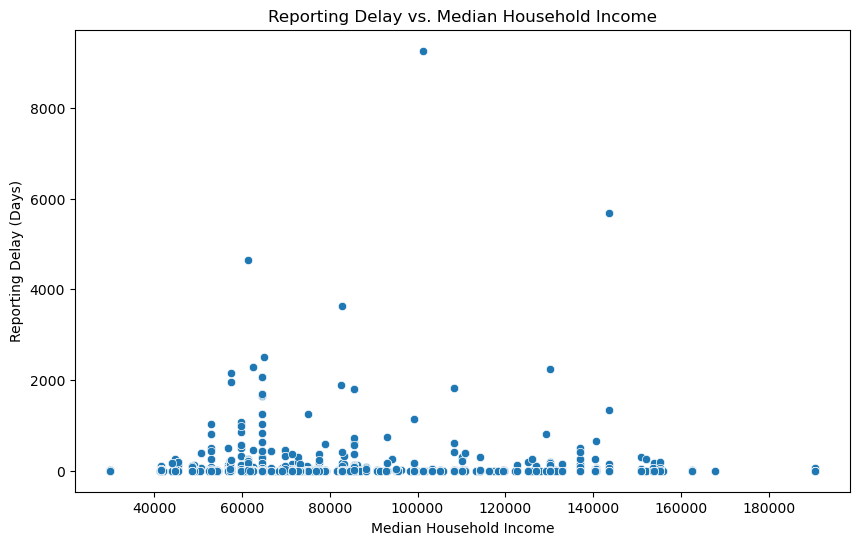

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of reporting delay vs. median household income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Reporting Delay (Days)')
plt.show()


In [11]:
import statsmodels.api as sm

# Define the independent variable (adding a constant for intercept)
X = sm.add_constant(spills_gdf['median_household_income'])

# Define the dependent variable
y = spills_gdf['Report Delay (Days)']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the model
model_summary = model.summary()
print(model_summary)


                             OLS Regression Results                            
Dep. Variable:     Report Delay (Days)   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.000
Method:                  Least Squares   F-statistic:                    0.2970
Date:                 Fri, 09 Aug 2024   Prob (F-statistic):              0.586
Time:                         15:56:51   Log-Likelihood:            -1.0577e+05
No. Observations:                16890   AIC:                         2.116e+05
Df Residuals:                    16888   BIC:                         2.116e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const           

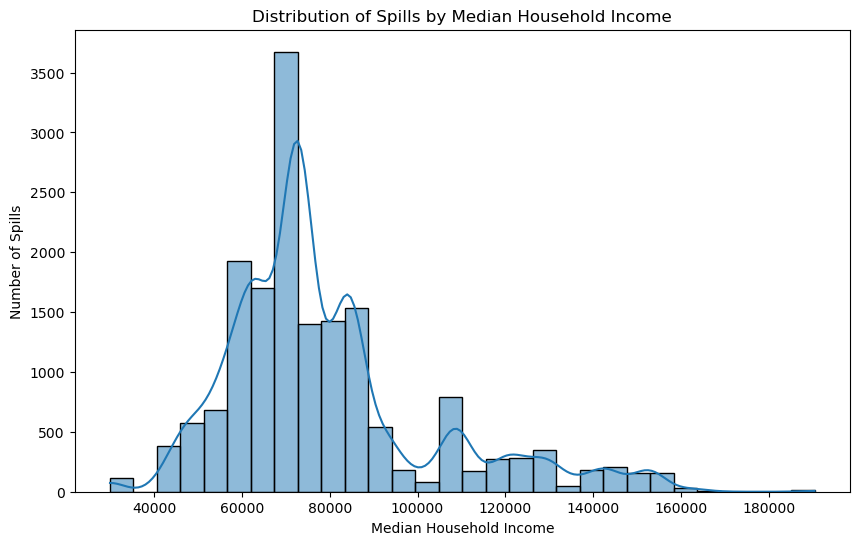

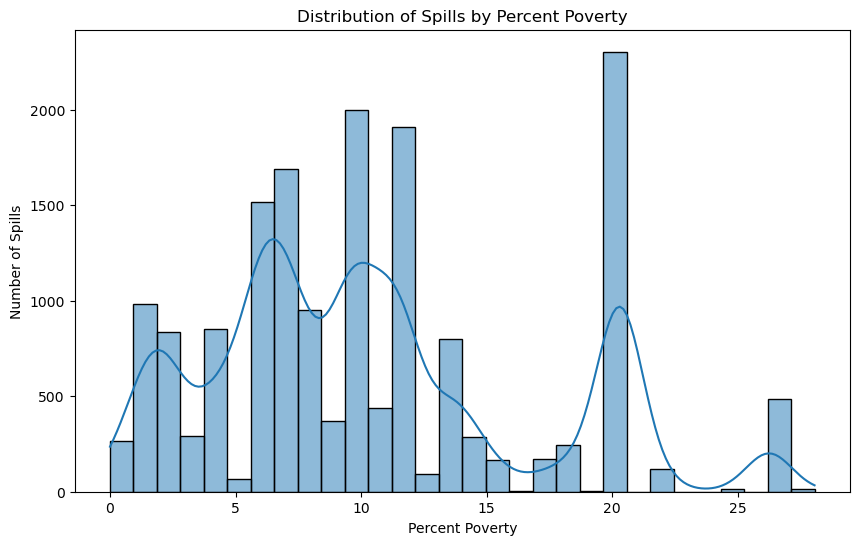

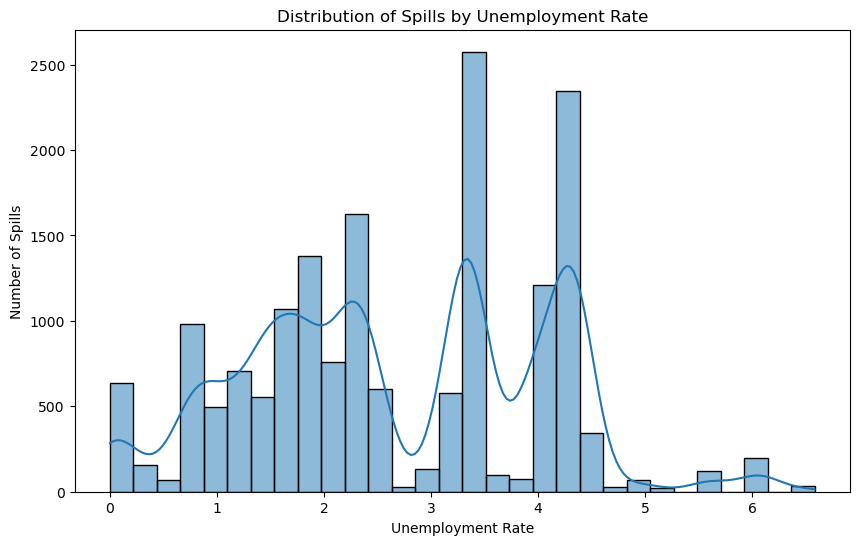

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot spill locations by median household income
plt.figure(figsize=(10, 6))
sns.histplot(data=spills_gdf, x='median_household_income', bins=30, kde=True)
plt.title('Distribution of Spills by Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Spills')
plt.show()

# Plot spill locations by percent poverty
plt.figure(figsize=(10, 6))
sns.histplot(data=spills_gdf, x='percent_poverty', bins=30, kde=True)
plt.title('Distribution of Spills by Percent Poverty')
plt.xlabel('Percent Poverty')
plt.ylabel('Number of Spills')
plt.show()

# Plot spill locations by unemployment rate
plt.figure(figsize=(10, 6))
sns.histplot(data=spills_gdf, x='unemployment_rate', bins=30, kde=True)
plt.title('Distribution of Spills by Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Number of Spills')
plt.show()


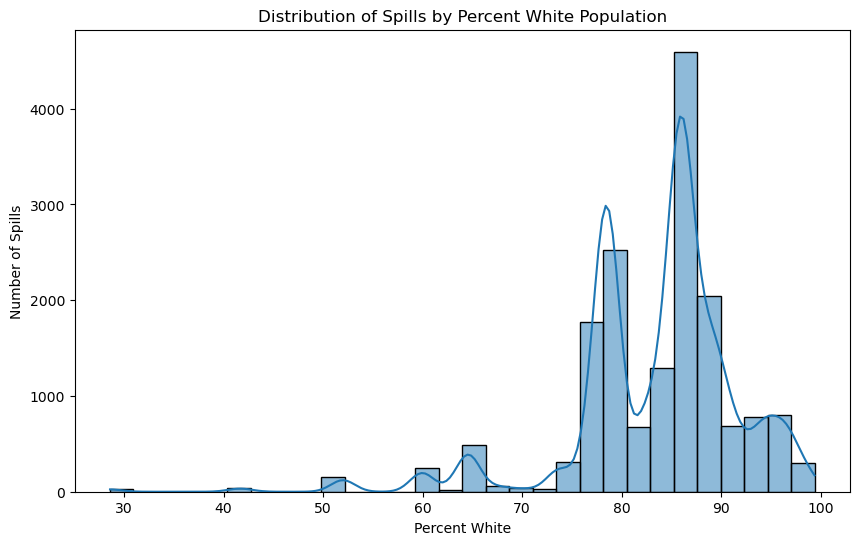

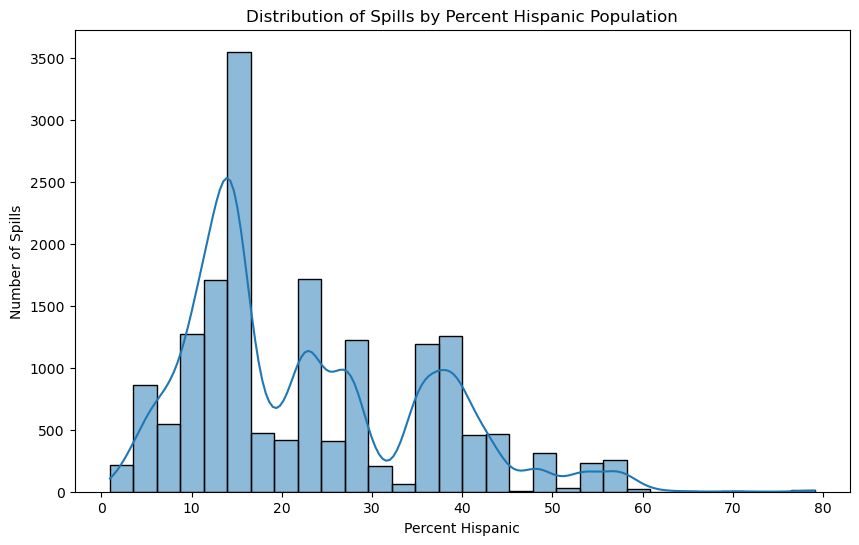

In [13]:
# Plot spill locations by percent white
plt.figure(figsize=(10, 6))
sns.histplot(data=spills_gdf, x='percent_white', bins=30, kde=True)
plt.title('Distribution of Spills by Percent White Population')
plt.xlabel('Percent White')
plt.ylabel('Number of Spills')
plt.show()

# Plot spill locations by percent hispanic
plt.figure(figsize=(10, 6))
sns.histplot(data=spills_gdf, x='percent_hispanic', bins=30, kde=True)
plt.title('Distribution of Spills by Percent Hispanic Population')
plt.xlabel('Percent Hispanic')
plt.ylabel('Number of Spills')
plt.show()


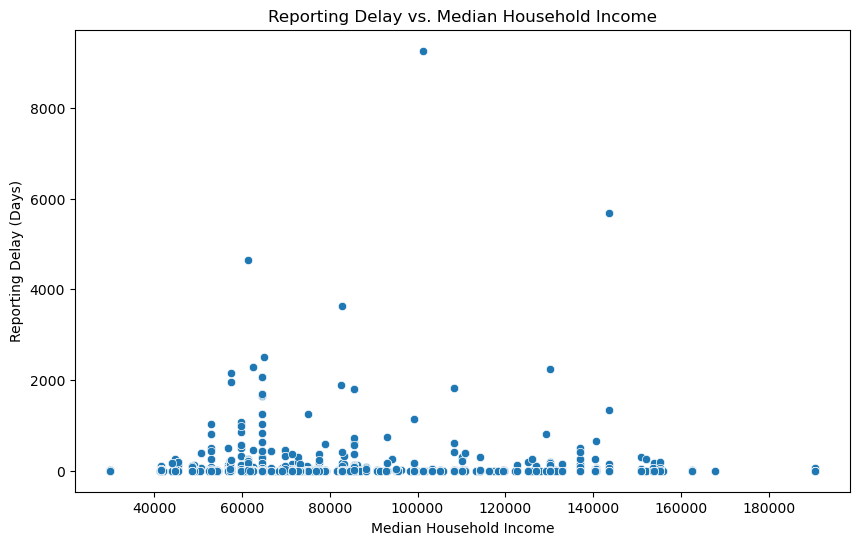

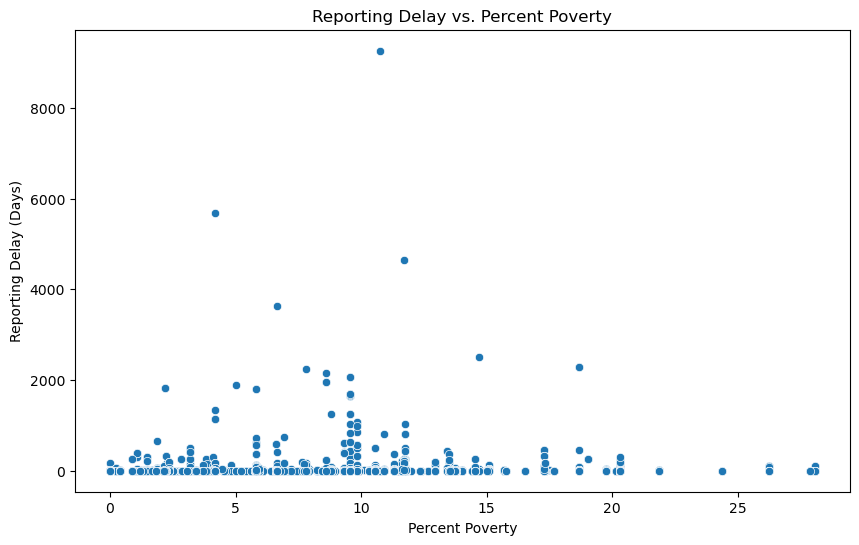

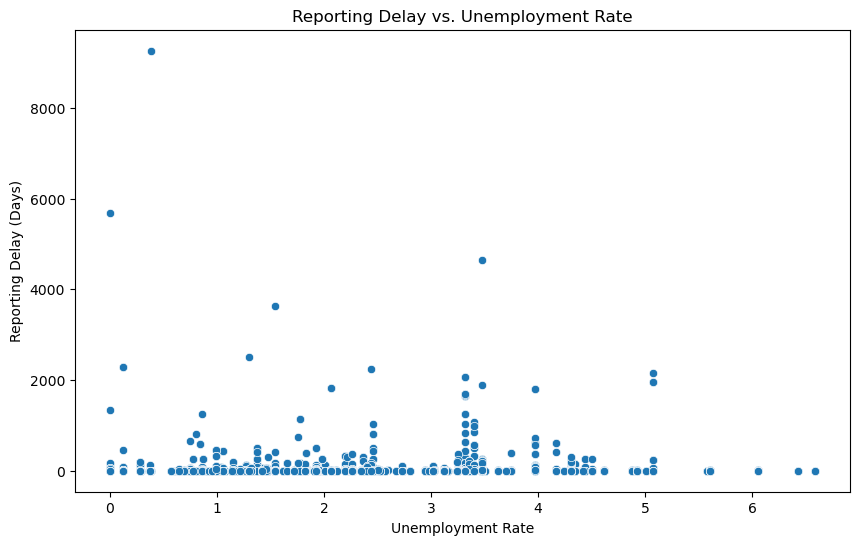

In [14]:
# Scatter plot of reporting delay vs. median household income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Median Household Income')
plt.xlabel('Median Household Income')
plt.ylabel('Reporting Delay (Days)')
plt.show()

# Scatter plot of reporting delay vs. percent poverty
plt.figure(figsize=(10, 6))
sns.scatterplot(x='percent_poverty', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Percent Poverty')
plt.xlabel('Percent Poverty')
plt.ylabel('Reporting Delay (Days)')
plt.show()

# Scatter plot of reporting delay vs. unemployment rate
plt.figure(figsize=(10, 6))
sns.scatterplot(x='unemployment_rate', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Reporting Delay (Days)')
plt.show()


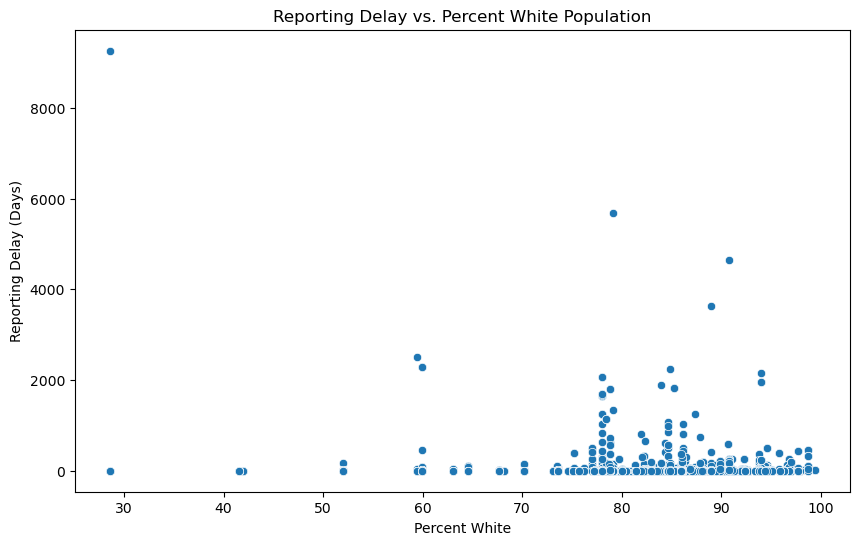

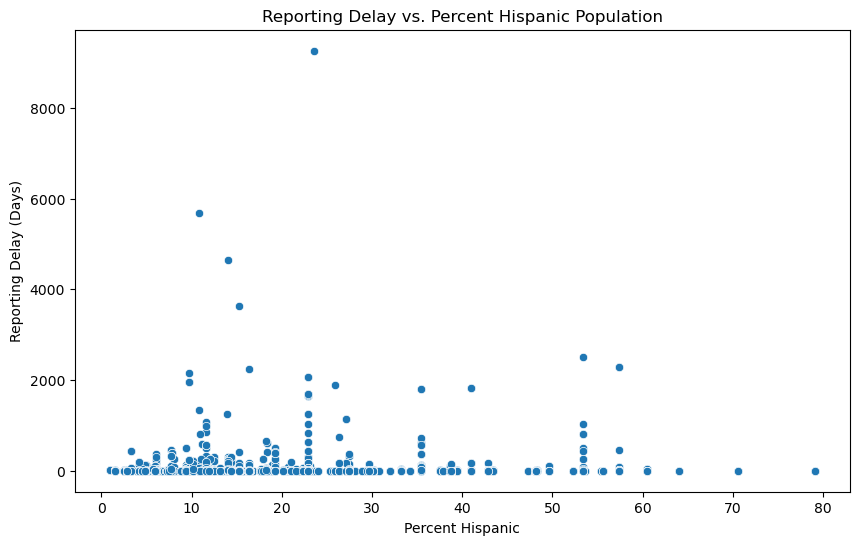

In [15]:
# Scatter plot of reporting delay vs. percent white
plt.figure(figsize=(10, 6))
sns.scatterplot(x='percent_white', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Percent White Population')
plt.xlabel('Percent White')
plt.ylabel('Reporting Delay (Days)')
plt.show()

# Scatter plot of reporting delay vs. percent hispanic
plt.figure(figsize=(10, 6))
sns.scatterplot(x='percent_hispanic', y='Report Delay (Days)', data=spills_gdf)
plt.title('Reporting Delay vs. Percent Hispanic Population')
plt.xlabel('Percent Hispanic')
plt.ylabel('Reporting Delay (Days)')
plt.show()


In [16]:
# Select relevant columns for correlation analysis
correlation_columns = [
    'Report Delay (Days)', 
    'median_household_income', 
    'percent_poverty', 
    'unemployment_rate', 
    'percent_white', 
    'percent_hispanic'
]

# Create a DataFrame with the selected columns
correlation_df = spills_gdf[correlation_columns]


In [17]:
# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

# Display the correlation matrix
correlation_matrix


,Report Delay (Days),median_household_income,percent_poverty,unemployment_rate,percent_white,percent_hispanic
Report Delay (Days),1.000000,0.004194,-0.011415,-0.008741,-0.033242,-0.003342
median_household_income,0.004194,1.000000,-0.572311,-0.218962,0.070998,-0.224321
percent_poverty,-0.011415,-0.572311,1.000000,0.374435,-0.093304,-0.032890
unemployment_rate,-0.008741,-0.218962,0.374435,1.000000,0.122596,-0.131676
percent_white,-0.033242,0.070998,-0.093304,0.122596,1.000000,-0.643538
percent_hispanic,-0.003342,-0.224321,-0.032890,-0.131676,-0.643538,1.000000


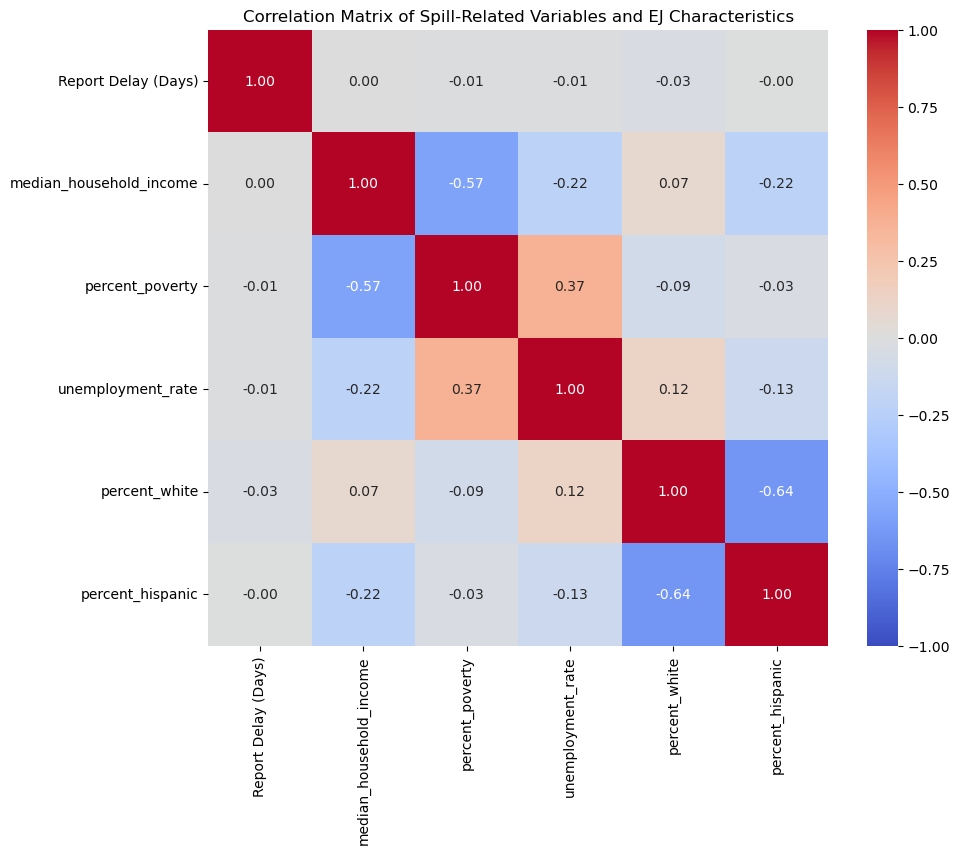

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

# Add title and labels
plt.title('Correlation Matrix of Spill-Related Variables and EJ Characteristics')
plt.show()


In [19]:
## Count the number of spills by operator
operator_spill_count = spills_gdf['Operator'].value_counts()

# Display the top operators with the most spills
operator_spill_count.head(10)


Operator
NOBLE ENERGY INC                              2402
KERR MCGEE OIL & GAS ONSHORE LP               2243
PDC ENERGY INC                                1182
CAERUS PICEANCE LLC                           1051
BONANZA CREEK ENERGY OPERATING COMPANY LLC     643
KP KAUFFMAN COMPANY INC                        468
CHEVRON USA INC                                467
HIGHPOINT OPERATING CORPORATION                411
CRESTONE PEAK RESOURCES OPERATING LLC          394
LARAMIE ENERGY LLC                             376
Name: count, dtype: int64

In [20]:
# Count the number of spills by county
county_spill_count = spills_gdf['county'].value_counts()

# Display the top counties with the most spills
county_spill_count.head(10)


county
WELD               9850
GARFIELD           1886
RIO BLANCO         1034
LAS ANIMAS          614
ADAMS               583
LA PLATA            496
MESA                362
JACKSON             271
YUMA                270
WASHINGTON          226
Name: count, dtype: int64

In [21]:
# Identify operators with more than one spill
recurring_operator_spills = operator_spill_count[operator_spill_count > 1]

# Display the operators with recurring spills
recurring_operator_spills


Operator
NOBLE ENERGY INC                              2402
KERR MCGEE OIL & GAS ONSHORE LP               2243
PDC ENERGY INC                                1182
CAERUS PICEANCE LLC                           1051
BONANZA CREEK ENERGY OPERATING COMPANY LLC     643
                                              ... 
WOLVERINE RESOURCES LLC                          2
DAN A HUGHES COMPANY LP                          2
SUMMIT MIDSTREAM NIOBRARA LLC                    2
LYSTER OIL COMPANY INC                           2
SOVEREIGN OPERATING COMPANY LLC                  2
Name: count, Length: 275, dtype: int64

In [22]:
# Identify counties with more than one spill
recurring_county_spills = county_spill_count[county_spill_count > 1]

# Display the counties with recurring spills
recurring_county_spills


county
WELD               9850
GARFIELD           1886
RIO BLANCO         1034
LAS ANIMAS          614
ADAMS               583
LA PLATA            496
MESA                362
JACKSON             271
YUMA                270
WASHINGTON          226
MOFFAT              172
ARAPAHOE            153
LARIMER             122
BOULDER             117
CHEYENNE            106
MONTEZUMA            97
LOGAN                85
LINCOLN              60
ARCHULETA            56
BROOMFIELD           52
ELBERT               50
GUNNISON             45
KIOWA                39
HUERFANO             32
MORGAN               31
BACA                 29
PROWERS              10
DOLORES               9
ROUTT                 9
KIT CARSON            8
PITKIN                7
DENVER                5
FREMONT               4
Name: count, dtype: int64

In [23]:
# Group by GEOID and aggregate the number of spills and demographic characteristics
tract_spill_summary = spills_gdf.groupby('GEOID').agg({
    'Document #': 'count',
    'median_household_income': 'mean',
    'percent_poverty': 'mean',
    'percent_white': 'mean'
}).rename(columns={'Document #': 'Number of Spills'})

# Display the summary
tract_spill_summary.head()


,Number of Spills,median_household_income,percent_poverty,percent_white
GEOID,,,,
08001008354,31,101250.0,10.757540,28.591783
08001008401,122,88286.0,5.918776,86.814788
08001008402,95,114276.0,4.121431,82.046643
08001008526,1,98283.0,3.801249,79.011675
08001008538,9,131231.0,4.150727,75.181714


In [24]:
# Calculate the correlation matrix for the tract-level data
correlation_matrix_tract = tract_spill_summary.corr()

# Display the correlation matrix
correlation_matrix_tract


,Number of Spills,median_household_income,percent_poverty,percent_white
Number of Spills,1.000000,-0.157514,0.133947,-0.008777
median_household_income,-0.157514,1.000000,-0.625752,-0.001162
percent_poverty,0.133947,-0.625752,1.000000,-0.067320
percent_white,-0.008777,-0.001162,-0.067320,1.000000


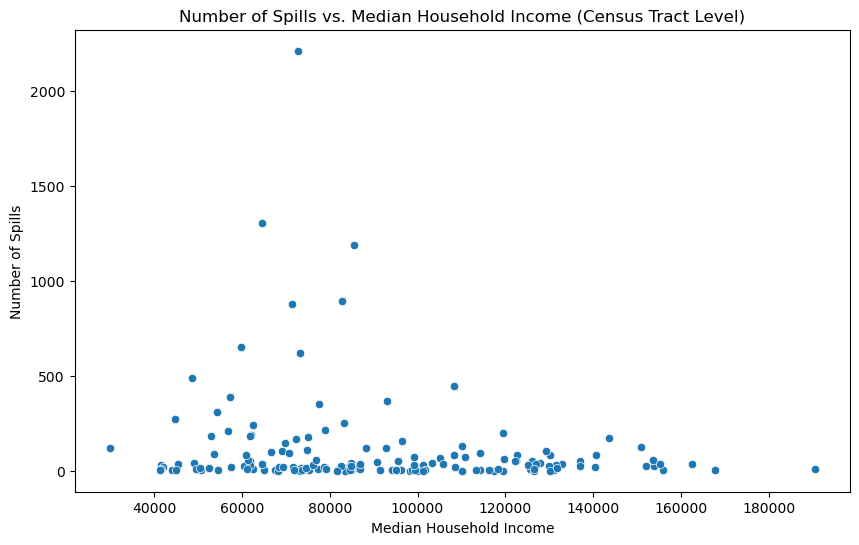

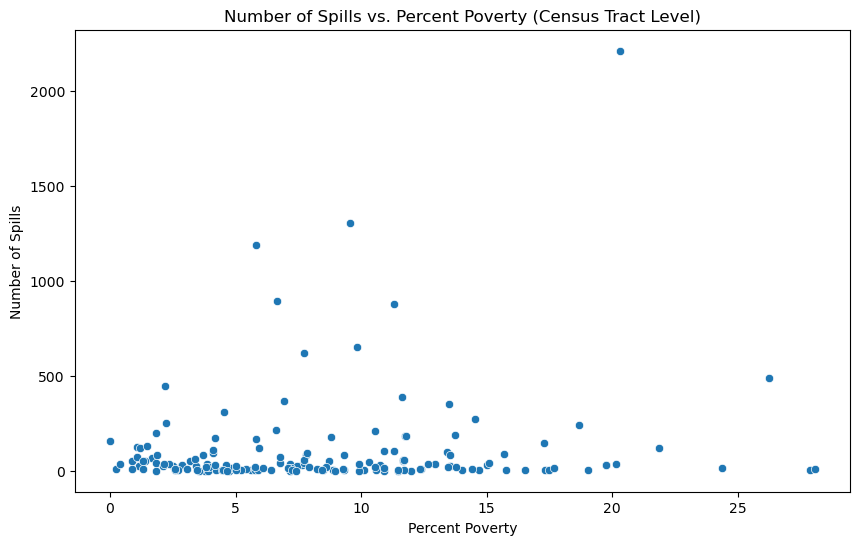

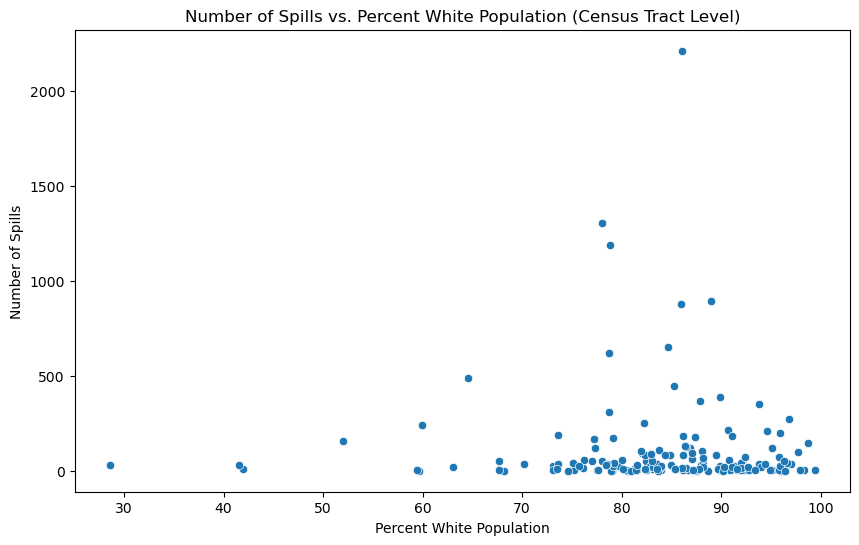

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of Number of Spills vs. Median Household Income
plt.figure(figsize=(10, 6))
sns.scatterplot(x='median_household_income', y='Number of Spills', data=tract_spill_summary)
plt.title('Number of Spills vs. Median Household Income (Census Tract Level)')
plt.xlabel('Median Household Income')
plt.ylabel('Number of Spills')
plt.show()

# Scatter plot of Number of Spills vs. Percent Poverty
plt.figure(figsize=(10, 6))
sns.scatterplot(x='percent_poverty', y='Number of Spills', data=tract_spill_summary)
plt.title('Number of Spills vs. Percent Poverty (Census Tract Level)')
plt.xlabel('Percent Poverty')
plt.ylabel('Number of Spills')
plt.show()

# Scatter plot of Number of Spills vs. Percent White Population
plt.figure(figsize=(10, 6))
sns.scatterplot(x='percent_white', y='Number of Spills', data=tract_spill_summary)
plt.title('Number of Spills vs. Percent White Population (Census Tract Level)')
plt.xlabel('Percent White Population')
plt.ylabel('Number of Spills')
plt.show()


In [26]:
# Remove rows with NaN or infinite values
tract_spill_summary_cleaned = tract_spill_summary.replace([np.inf, -np.inf], np.nan).dropna()

# Check that the data is clean
tract_spill_summary_cleaned.isna().sum()


Number of Spills           0
median_household_income    0
percent_poverty            0
percent_white              0
dtype: int64

In [27]:
# Define the independent variables (with a constant for intercept)
X = tract_spill_summary_cleaned[['median_household_income', 'percent_poverty', 'percent_white']]
X = sm.add_constant(X)

# Define the dependent variable
y = tract_spill_summary_cleaned['Number of Spills']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Get the summary of the model
model_summary = model.summary()
print(model_summary)


                            OLS Regression Results                            
Dep. Variable:       Number of Spills   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.403
Date:                Fri, 09 Aug 2024   Prob (F-statistic):              0.244
Time:                        15:56:53   Log-Likelihood:                -1091.6
No. Observations:                 157   AIC:                             2191.
Df Residuals:                     153   BIC:                             2203.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [28]:
# Re-calculate the correlation matrix
correlation_matrix_cleaned = tract_spill_summary_cleaned.corr()

# Display the cleaned correlation matrix
correlation_matrix_cleaned


,Number of Spills,median_household_income,percent_poverty,percent_white
Number of Spills,1.000000,-0.157012,0.133947,-0.008777
median_household_income,-0.157012,1.000000,-0.625752,-0.001162
percent_poverty,0.133947,-0.625752,1.000000,-0.067320
percent_white,-0.008777,-0.001162,-0.067320,1.000000


In [30]:
# Ensure the 'Initial Report Date' is in datetime format
spills_gdf['Initial Report Date'] = pd.to_datetime(spills_gdf['Initial Report Date'])

# Extract the year from the 'Initial Report Date'
spills_gdf['Report Year'] = spills_gdf['Initial Report Date'].dt.year

# Display the first few rows to verify the new column
spills_gdf[['Initial Report Date', 'Report Year']].head()


,Initial Report Date,Report Year
0,2014-06-18,2014
1,2014-06-19,2014
2,2014-06-19,2014
3,2014-06-20,2014
4,2014-06-23,2014


In [38]:
# Filter the data for years 2015 to 2023
spills_gdf_filtered = spills_gdf[(spills_gdf['Report Year'] >= 2015) & (spills_gdf['Report Year'] <= 2023)]

# Filter the data to include only spills reported from January to August
spills_gdf_filtered = spills_gdf_filtered[spills_gdf_filtered['Report Month'] <= 8]

# Group by year and count the number of spills for each year up to August
spills_by_year_filtered = spills_gdf_filtered.groupby('Report Year').size().reset_index(name='Number of Spills')

# Calculate the average number of spills per month for each year (January-August)
spills_by_year_filtered['Average Spills (Jan-Aug)'] = spills_by_year_filtered['Number of Spills'] / 8

# Display the result
spills_by_year_filtered


,Report Year,Number of Spills,Average Spills (Jan-Aug)
0,2015,1145,143.125
1,2016,900,112.500
2,2017,1100,137.500
3,2018,1069,133.625
4,2019,1056,132.000
5,2020,827,103.375
6,2021,1143,142.875
7,2022,1465,183.125
8,2023,1420,177.500


# Reporting Delay by Year

In [33]:
# Group by 'Report Year' and calculate the average reporting delay
report_delay_by_year = spills_gdf.groupby('Report Year')['Report Delay (Days)'].mean().reset_index(name='Average Report Delay (Days)')

# Display the average reporting delay by year
report_delay_by_year


,Report Year,Average Report Delay (Days)
0,2014,5.991485
1,2015,31.561963
2,2016,8.813953
3,2017,4.448169
4,2018,2.939987
5,2019,16.108612
6,2020,12.212947
7,2021,3.074157
8,2022,7.804287
9,2023,6.325469


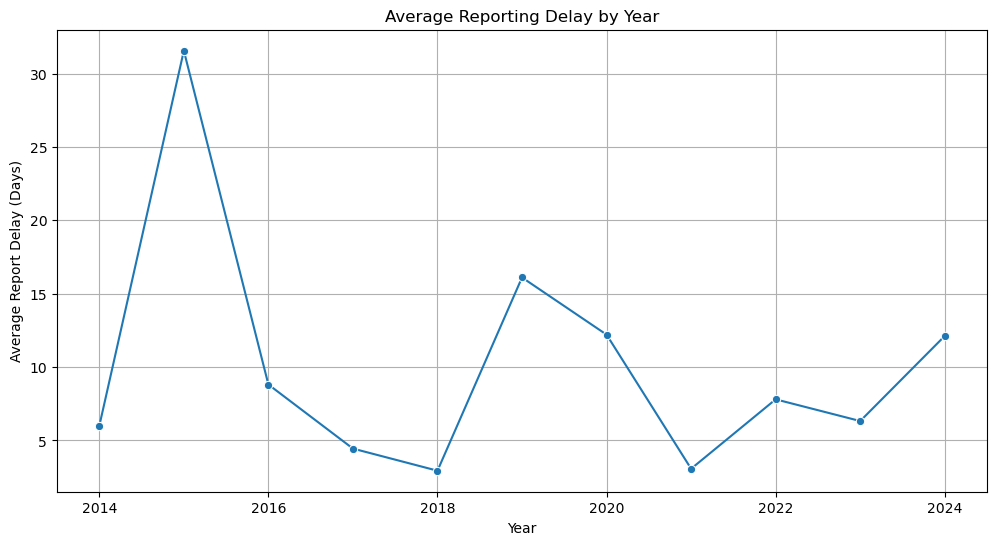

In [34]:
# Plot the average reporting delay by year
plt.figure(figsize=(12, 6))
sns.lineplot(x='Report Year', y='Average Report Delay (Days)', data=report_delay_by_year, marker='o')
plt.title('Average Reporting Delay by Year')
plt.xlabel('Year')
plt.ylabel('Average Report Delay (Days)')
plt.grid(True)
plt.show()


In [41]:
# Filter the data for years 2015 to 2023
spill_gdf_filtered = spills_gdf[(spills_gdf['Report Year'] >= 2015) & (spills_gdf['Report Year'] <= 2023)]


In [42]:
# Group by year and month, then count the number of spills
spills_by_month = spills_gdf_filtered.groupby(['Report Year', 'Report Month']).size().reset_index(name='Number of Spills')

# Calculate the average number of spills per month for each year
monthly_average_spills = spills_by_month.groupby('Report Year')['Number of Spills'].mean().reset_index(name='Average Spills per Month')

# Display the result
monthly_average_spills


,Report Year,Average Spills per Month
0,2015,143.125
1,2016,112.500
2,2017,137.500
3,2018,133.625
4,2019,132.000
5,2020,103.375
6,2021,142.875
7,2022,183.125
8,2023,177.500


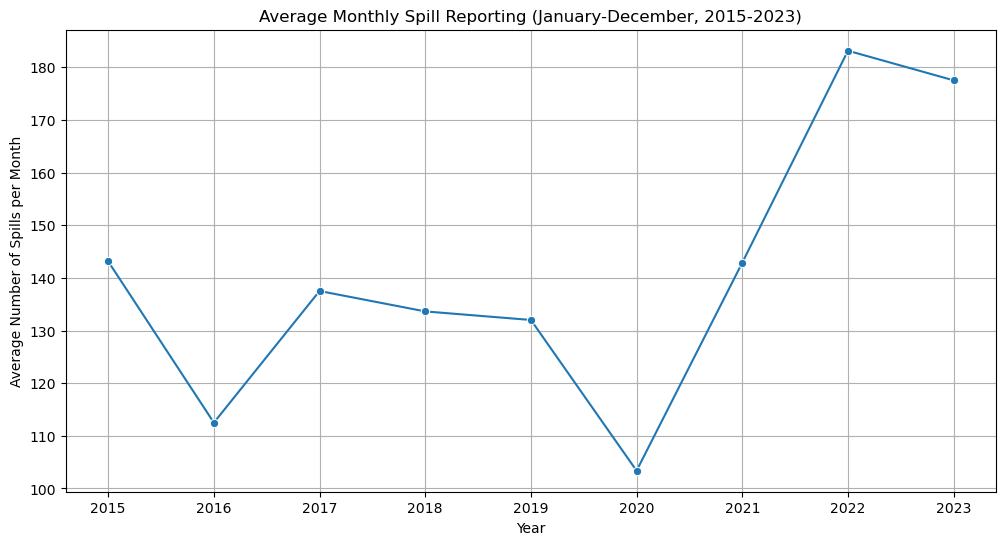

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the average number of spills per month for each year (2015-2023)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Report Year', y='Average Spills per Month', data=monthly_average_spills, marker='o')
plt.title('Average Monthly Spill Reporting (January-December, 2015-2023)')
plt.xlabel('Year')
plt.ylabel('Average Number of Spills per Month')
plt.grid(True)
plt.show()
